<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Copy_of_Sentiment_analysis_for_Hotels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. **Data Exploration**

In [105]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline





import itertools


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [89]:
!pip install catboost

     |████████████████████████████████| 65.9MB 70kB/s 


/usr/local/lib/python3.6/dist-packages/google/colab/_pip.py:87: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.6/dist-packages/catboost-0.24.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


**Load Dataset**

In [2]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving Tripadvisor Datasource.csv to Tripadvisor Datasource.csv


In [106]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['Tripadvisor Datasource.csv']))

In [ ]:
data.head()

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Rating
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,5
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,5
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,5
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,4
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,5


In [107]:
# Print Multiple statements in same line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

**Data** Exploration and Data Visualization 

In [108]:
#Explore Data
data.shape
type(data)
data.size
data.shape
data.head()
data.tail()
data.info()

(701, 7)

pandas.core.frame.DataFrame

4907

(701, 7)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Rating
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,5
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,5
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,5
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,4
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,5


,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Rating
696,g297628-d1483784,Melange Astris,r727852519,Value for money ...,Ravi Venkatraman,One of the finest property in the Center of Be...,5
697,g297628-d1483784,Melange Astris,r720634348,Third and last time,GSVCA,This was our third time staying at the Melange...,3
698,g297628-d1483784,Melange Astris,r714050308,First class hotel and absolute bargain,Fast_Mini,9th hotel in 13 days during a business trip ac...,5
699,g297628-d1483784,Melange Astris,r706524762,great stay..,VRam,My most profferers stay in Bangalore. Hotel is...,5
700,g297628-d1483784,Melange Astris,r517289155,Pleasant stay !!,WonderSpinach,Was here on business for 2 days.. the hotel is...,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Hotel_id   701 non-null    object
 1   Hotel      701 non-null    object
 2   Review_id  699 non-null    object
 3   Title      701 non-null    object
 4   Users      701 non-null    object
 5   Reviews    701 non-null    object
 6   Rating     701 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 38.5+ KB


In [109]:
# Ratings Count
data.Rating.value_counts()

5    554
4     98
3     28
1     13
2      8
Name: Rating, dtype: int64

In [110]:
print("Mean rating : {}".format(data['Rating'].mean()))
print("Mean rating standard deviation: {}".format(data['Rating'].std()))

Mean rating : 4.671897289586306
Mean rating standard deviation: 0.7695419570895506


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Rating')

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Count')

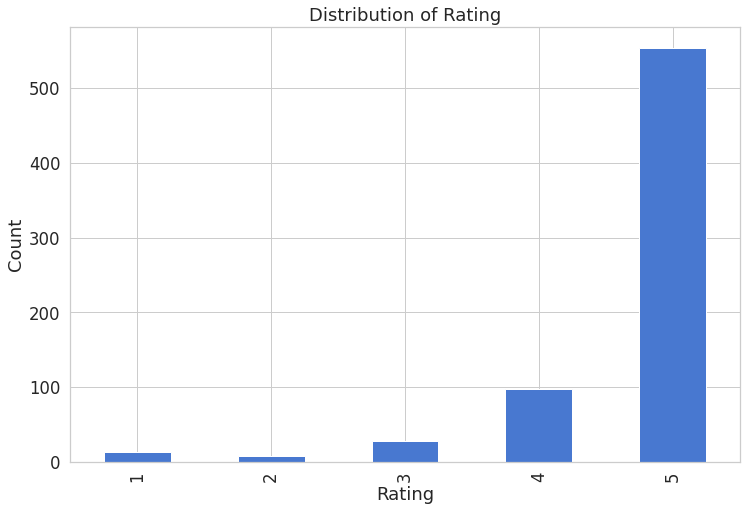

In [111]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
data['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

(array([ 13.,   0.,   8.,   0.,   0.,  28.,   0.,  97.,   0., 553.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'mean rating given by each reviewer')

Text(0, 0.5, 'number of reviewers')

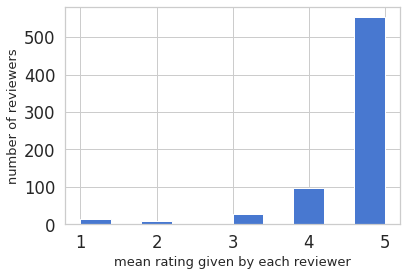

In [112]:
mean_rating_of_user = data.groupby('Review_id').apply(lambda x: x['Rating'].mean())

fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

In [113]:
# Dividing the Sentiment into "Positive" and "Negative" w.r.t to the Rating
data['Sentiment'] = data['Rating'].apply(lambda Rating: 'Positive' if Rating > 3 else 'Negative')
data.head(5)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Rating,Sentiment
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,5,Positive
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,5,Positive
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,5,Positive
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,4,Positive
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,5,Positive


In [114]:
# Sentiment Count
data.Sentiment.value_counts()


Positive    652
Negative     49
Name: Sentiment, dtype: int64

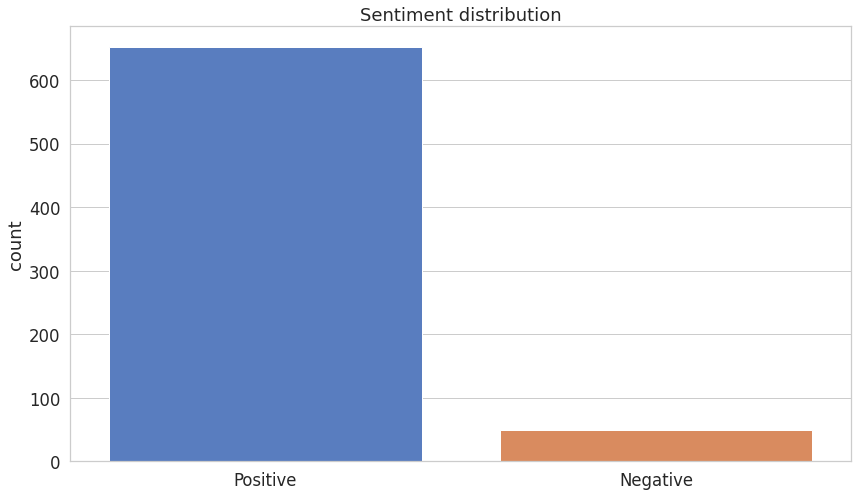

In [115]:
# Plot Showing Sentiment Distribution
f = sns.countplot(x='Sentiment', data=data)
f.set_title("Sentiment distribution")
f.set_xticklabels(['Positive', 'Negative'])
plt.xlabel("");

In [116]:
positive_sentiment=data[data['Sentiment'] == 'Positive']
negative_sentiment=data[data['Sentiment']=='Negative']

In [117]:

Reviews_all=" ".join(review for review in data.Sentiment)
Reviews_positive=" ".join(review for review in positive_sentiment.Reviews)
Reviews_negative=" ".join(review for review in negative_sentiment.Reviews)

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


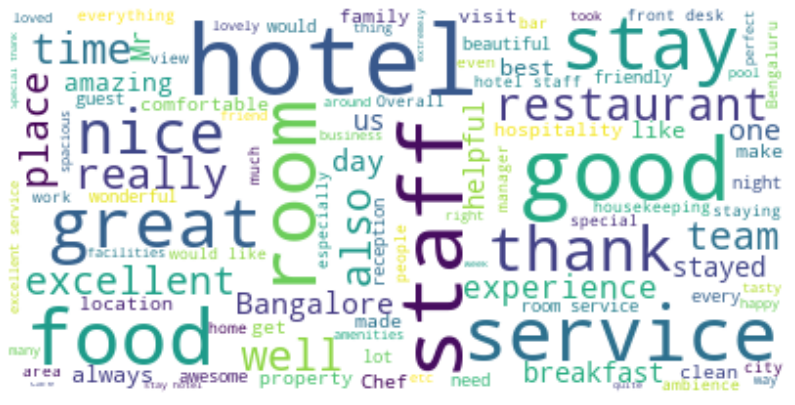

In [118]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(Reviews_positive)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


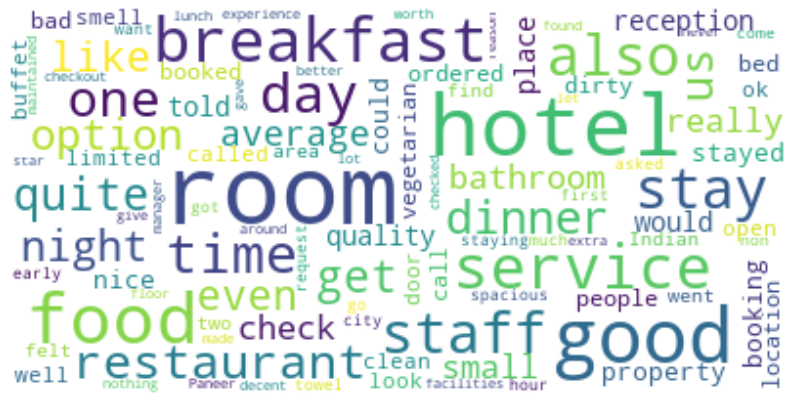

In [119]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(Reviews_negative)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

3. **Text Processing**

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

1.remove Punctuations 

2.Tokenization and Lematization

3.convert to lower case

4.remove stop words such as "the" and "and" if needed










In [120]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Reviews'].apply(lambda x: remove_punct(x))

In [121]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]

In [122]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [123]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

/usr/local/lib/python3.6/dist-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/root/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [124]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [125]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]

In [126]:
result = [' '.join(sen) for sen in filtered_words]

In [127]:
data['Text_Clean'] = result

In [128]:
# Showing the Review of index "3" after the text pre-processing
result[3]

'stayed 7 days really happy service provided worth rates low due govts intervention want highlight good points experienced inspite limited staff availablity 1 prepared fresh hot dinner midnightaround 1am served everyone checked time 2 facing wifi connectivity issues room coffee kettle work properly lead splash requested clean fix wifi issue offered new room wifi router defective room much better compared previous one 3 service punctual breakfast lunch dinner room dining food tasty healthy overall took'

In [129]:
data['tokens'] = filtered_words


In [130]:
data = data[['Hotel_id','Hotel','Review_id','Title','Users','Reviews','Text_Clean', 'Rating','tokens','Sentiment']]
data.head(5)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,memorable stay royal orchid central friendly s...,5,"[memorable, stay, royal, orchid, central, frie...",Positive
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,things happen time remember long timethe trip ...,5,"[things, happen, time, remember, long, timethe...",Positive
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,stay comfortable e delightfulthis ia first vis...,5,"[stay, comfortable, e, delightfulthis, ia, fir...",Positive
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,stayed 7 days really happy service provided wo...,4,"[stayed, 7, days, really, happy, service, prov...",Positive
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,comfortable stay services staff good ambience ...,5,"[comfortable, stay, services, staff, good, amb...",Positive


In [131]:
# The "Positive" Sentiment has been labelled as "1" and the "Negative" as "0"
data['Label'] = data['Sentiment'].apply(lambda Sentiment: '1' if Sentiment is 'Positive' else '0')
data.head(5)

,Hotel_id,Hotel,Review_id,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment,Label
0,g297628-d503249,Royal Orchid Central,r758572477,Great hospitality,Afreen A,It was very memorable stay at Royal orchid cen...,memorable stay royal orchid central friendly s...,5,"[memorable, stay, royal, orchid, central, frie...",Positive,1
1,g297628-d503249,Royal Orchid Central,r758007447,A royal living,Srikumar D,The Things happen with the time remember for l...,things happen time remember long timethe trip ...,5,"[things, happen, time, remember, long, timethe...",Positive,1
2,g297628-d503249,Royal Orchid Central,r757841035,Delight stay,devendranakka,My. stay was very comfortable e delightful.Thi...,stay comfortable e delightfulthis ia first vis...,5,"[stay, comfortable, e, delightfulthis, ia, fir...",Positive,1
3,g297628-d503249,Royal Orchid Central,r757272486,Institutional quarantine,Ashesha G Bhatta,I stayed here for 7 days & I was really happy ...,stayed 7 days really happy service provided wo...,4,"[stayed, 7, days, really, happy, service, prov...",Positive,1
4,g297628-d503249,Royal Orchid Central,r757252794,Wonderful stay,Jaya,Had a very comfortable stay. Services of staff...,comfortable stay services staff good ambience ...,5,"[comfortable, stay, services, staff, good, amb...",Positive,1


Splitting Dataset into Train and Test Set¶
**bold text**

In [132]:
# Splitting the Data Set into Train and Test Sets
X = data['Text_Clean']
y = data['Label']

In [133]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [134]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(560,)
Test Set Shape		:(141,)


**Confusion Matrix Plot Function**


In [135]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'Positive' and 'Negative' Sentiments 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [136]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

**4.Modelling**


This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by customers who bought headphones products in Amazon e-commerce online platform. We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. Besides that, I implemented deep learning technique with Keras.

Since the ratings of the reviews were not distributed normally, I decided to decrease rating classes from 5 to 2 by merging Rating 1-2-3 as 'Negative' and Rating 4-5 as 'Positive'.

For feature selection, I applied threshold for word occurence with using min_df/max_df, PCA and Singular Value Decomposition.

For feature engineering, I applied CountVectorizer, TF-IDF, Hashing Vectorizer and Word2Vec to the text data in order to turn a collection of text documents into numerical feature vectors.

4.1 CountVectorizer Bag of Words¶

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

"CountVectorizer" implements both tokenization and occurrence counting in a single class

In [137]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [138]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 4379


In [139]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [140]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,03days,04,04th,05km,06,07years,08dec19,10,100,1000,100100,1010,1016,10pm,10th,11,12,1200,1215,13,1300hrsthe,13th,14,15,1500,1520,15daysservice,15mar,16th,18,19,1am,1mar,1st,20,2019,2020,20char,21,210,...,worth,would,wow,wraparound,wraps,writing,written,wrong,yaman,yashwantpur,yatai,yeah,year,years,yellow,yes,yeshwanthpur,yeshwantpur,yess,yesterday,yet,yogesh,young,younger,youre,youwhat,yummy,zahed,zayed,zeeshan,zeroed,zodiac,zone,zoo,¾ðÿ,âœœï,ðÿ,œzone,œâœœï,œðÿ
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Creating a function for applying different algorithms¶


In [141]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

**Dummy Classifier**


In [142]:
clf = DummyClassifier(strategy = 'stratified', random_state =42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

DummyClassifier(constant=None, random_state=42, strategy='stratified')

f1 score: 0.8647068377456552


In [143]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.93      0.92      0.92       132

    accuracy                           0.86       141
   macro avg       0.47      0.46      0.46       141
weighted avg       0.87      0.86      0.86       141



**Logistic Regression with CountVectorizer**

In [144]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.9549472084466486


Classification Report¶


In [145]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.71      0.56      0.63         9
           1       0.97      0.98      0.98       132

    accuracy                           0.96       141
   macro avg       0.84      0.77      0.80       141
weighted avg       0.95      0.96      0.95       141



Confusion Matrix¶


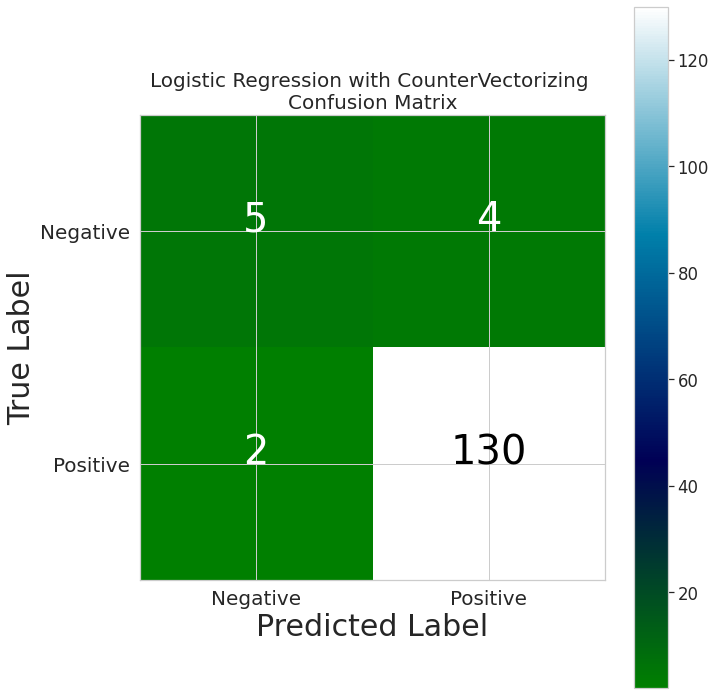

In [146]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

**Random Forest with CountVectorizer**

In [147]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.9053074584989479


Classification Report¶


In [148]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.94      1.00      0.97       132

    accuracy                           0.94       141
   macro avg       0.47      0.50      0.48       141
weighted avg       0.88      0.94      0.91       141



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix¶
**bold text**

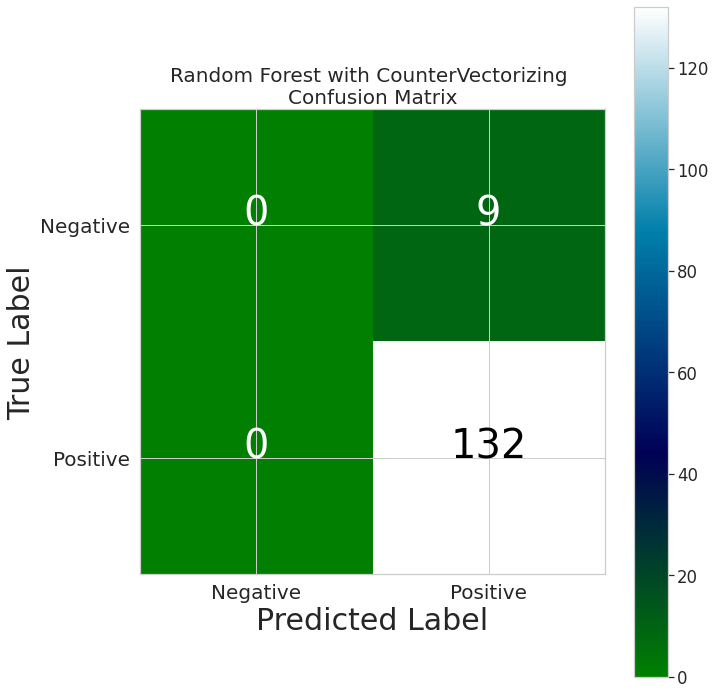

In [149]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

**Naive Bayes with CountVectorizer**

In [150]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.9214017521902379


Classification Report¶


In [151]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.94      1.00      0.97       132

    accuracy                           0.94       141
   macro avg       0.97      0.56      0.59       141
weighted avg       0.95      0.94      0.92       141



Confusion Matrix¶


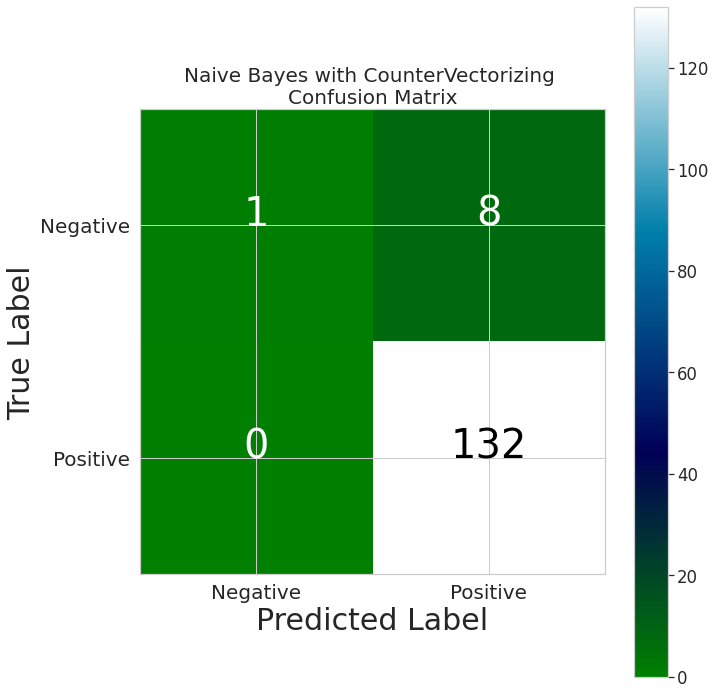

In [152]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

**XG Boost with CountVectorizer**

In [153]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.9297084318360913


Classification Report¶


In [154]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.95      0.99      0.97       132

    accuracy                           0.94       141
   macro avg       0.81      0.61      0.65       141
weighted avg       0.93      0.94      0.93       141



Confusion Matrix¶


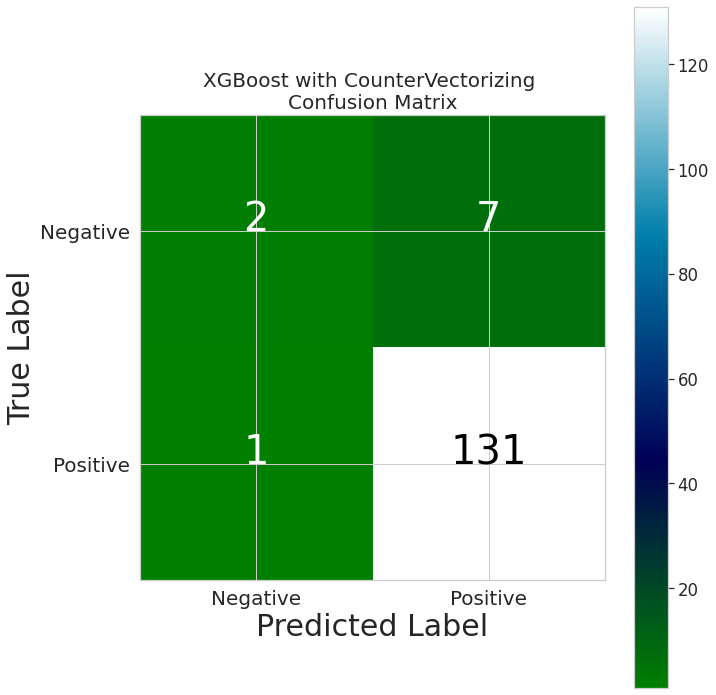

In [155]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

**CatBoost with CountVectorizer**

In [156]:
# Call the modeling function for CatBoost with countvectorizer and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, 
                            depth=2, loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.2684065	total: 6.11ms	remaining: 604ms
1:	learn: 0.2386098	total: 11.6ms	remaining: 571ms
2:	learn: 0.2222086	total: 16.5ms	remaining: 532ms
3:	learn: 0.1917414	total: 21.1ms	remaining: 506ms
4:	learn: 0.1649398	total: 25.6ms	remaining: 486ms
5:	learn: 0.1537692	total: 30.2ms	remaining: 474ms
6:	learn: 0.1295935	total: 35.5ms	remaining: 471ms
7:	learn: 0.1223706	total: 40.1ms	remaining: 461ms
8:	learn: 0.1120672	total: 44.6ms	remaining: 451ms
9:	learn: 0.1045335	total: 49.4ms	remaining: 444ms
10:	learn: 0.0991828	total: 53.9ms	remaining: 436ms
11:	learn: 0.0916297	total: 58.4ms	remaining: 428ms
12:	learn: 0.0858487	total: 62.8ms	remaining: 420ms
13:	learn: 0.0812545	total: 68.5ms	remaining: 421ms
14:	learn: 0.0743607	total: 75.2ms	remaining: 426ms
15:	learn: 0.0698982	total: 80.9ms	remaining: 425ms
16:	learn: 0.0658492	total: 85.9ms	remaining: 419ms
17:	learn: 0.0620764	total: 91.3ms	remaining: 416ms
18:	learn: 0.0572465	total: 96.3ms	remaining: 410ms
19:	learn: 0.0550152	t

Classification Report¶


In [157]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.33      0.11      0.17         9
           1       0.94      0.98      0.96       132

    accuracy                           0.93       141
   macro avg       0.64      0.55      0.56       141
weighted avg       0.90      0.93      0.91       141



Confusion Matrix¶


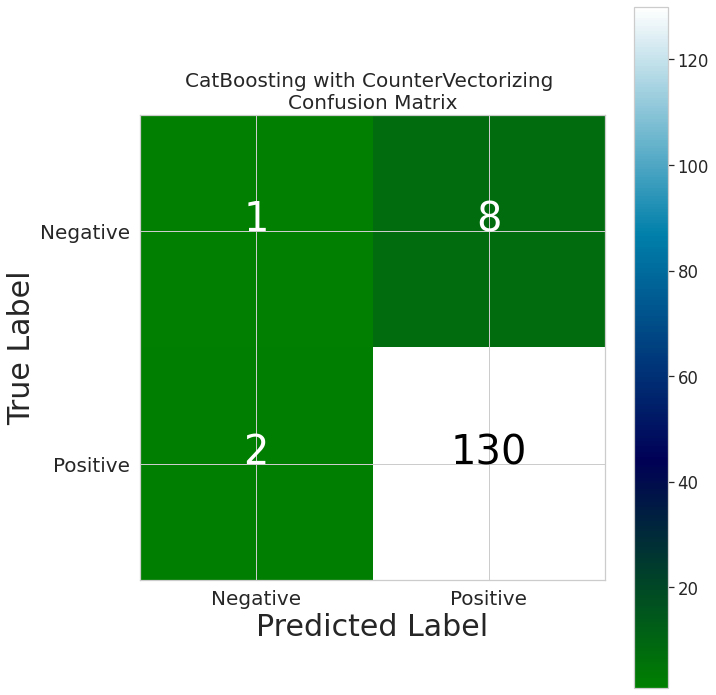

In [158]:

# Print confusion matrix for CatBoost with countVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting")

Comparison of Models with CountVectorizer
**bold text**

In [159]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['negative','positive']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [220]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])
    

    
   



In [221]:
    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

ValueError: ignored

Function for f1 Score Plotting¶
**bold text**

In [161]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

In [168]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])
               

ValueError: ignored

In [190]:
df_tv2

NameError: ignored

In [169]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

In [170]:
# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.9574468085106383


In [171]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.98      0.98      0.98       132

    accuracy                           0.96       141
   macro avg       0.82      0.82      0.82       141
weighted avg       0.96      0.96      0.96       141



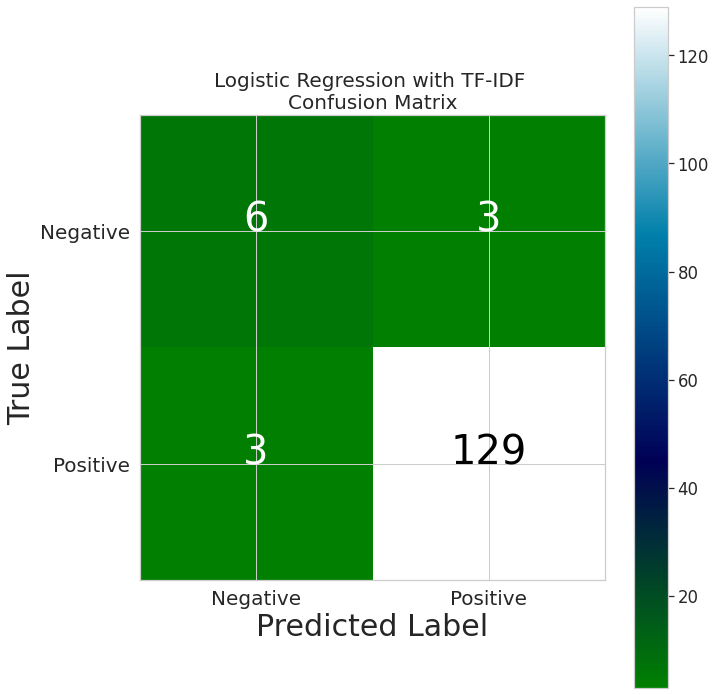

In [172]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

Random Forest with TF-IDF¶


In [173]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.9053074584989479


In [174]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.94      1.00      0.97       132

    accuracy                           0.94       141
   macro avg       0.47      0.50      0.48       141
weighted avg       0.88      0.94      0.91       141



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


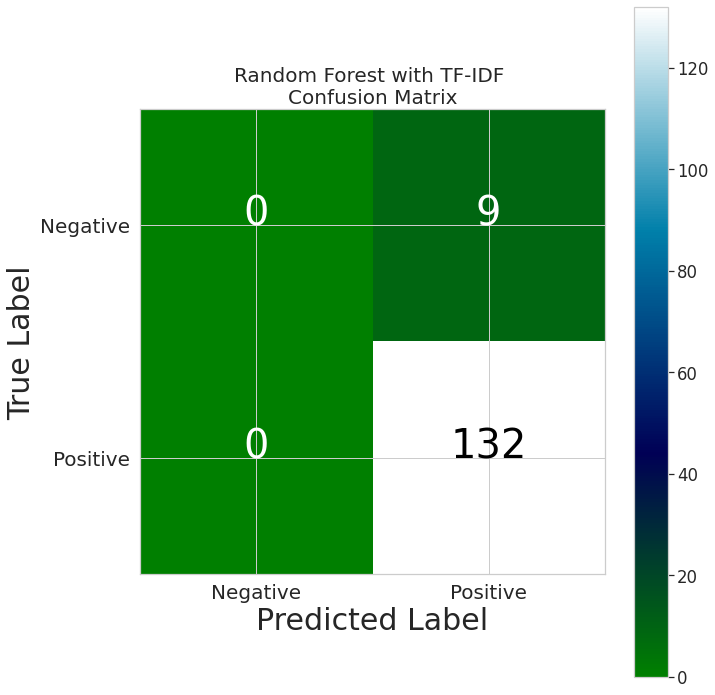

In [175]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

**Naive Bayes with TF-IDF**

In [177]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.9053074584989479


In [178]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.94      1.00      0.97       132

    accuracy                           0.94       141
   macro avg       0.47      0.50      0.48       141
weighted avg       0.88      0.94      0.91       141



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


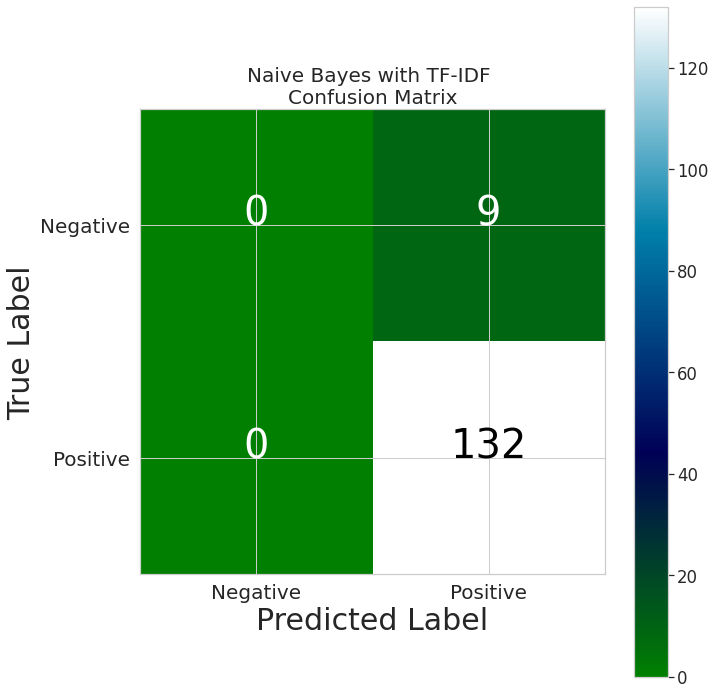

In [179]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

**XGBoost with TF-IDF**

In [180]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

f1 score: 0.9121355397951143


In [181]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.33      0.11      0.17         9
           1       0.94      0.98      0.96       132

    accuracy                           0.93       141
   macro avg       0.64      0.55      0.56       141
weighted avg       0.90      0.93      0.91       141



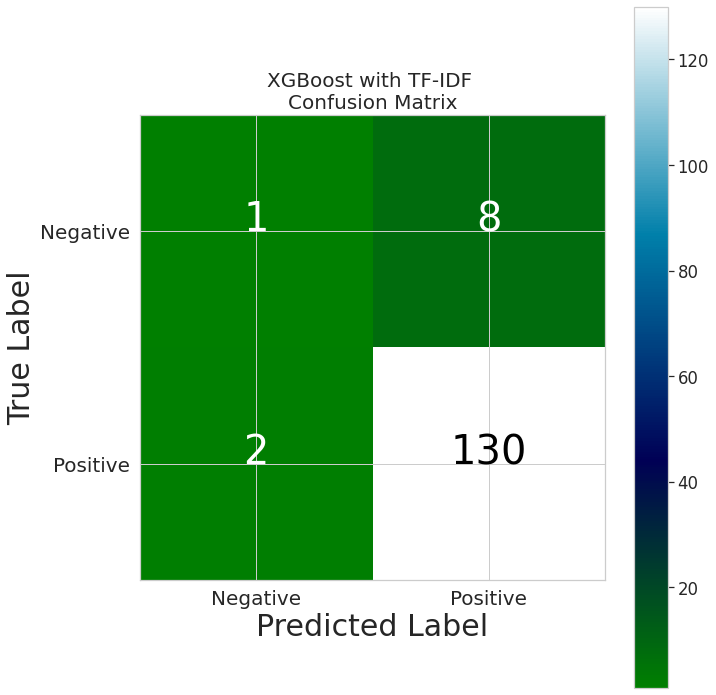

In [182]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

**CatBoost with TF-IDF**

In [183]:
# Call the modeling function for Catboost with TF-IDF and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_catboost = y_pred

0:	learn: 0.2634415	total: 8.28ms	remaining: 820ms
1:	learn: 0.2174576	total: 14.4ms	remaining: 707ms
2:	learn: 0.2006942	total: 20ms	remaining: 648ms
3:	learn: 0.1864571	total: 25.5ms	remaining: 613ms
4:	learn: 0.1692956	total: 31.1ms	remaining: 591ms
5:	learn: 0.1547117	total: 36.6ms	remaining: 574ms
6:	learn: 0.1366014	total: 42.3ms	remaining: 562ms
7:	learn: 0.1194716	total: 47.9ms	remaining: 551ms
8:	learn: 0.1087530	total: 53.5ms	remaining: 540ms
9:	learn: 0.0990961	total: 58.9ms	remaining: 530ms
10:	learn: 0.0814402	total: 64.5ms	remaining: 522ms
11:	learn: 0.0743440	total: 70.1ms	remaining: 514ms
12:	learn: 0.0675991	total: 75.7ms	remaining: 507ms
13:	learn: 0.0640655	total: 81.3ms	remaining: 500ms
14:	learn: 0.0599969	total: 87ms	remaining: 493ms
15:	learn: 0.0515652	total: 92.6ms	remaining: 486ms
16:	learn: 0.0450046	total: 98.5ms	remaining: 481ms
17:	learn: 0.0418405	total: 104ms	remaining: 475ms
18:	learn: 0.0384219	total: 110ms	remaining: 468ms
19:	learn: 0.0364999	total: 

In [184]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_catboost))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.94      0.98      0.96       132

    accuracy                           0.92       141
   macro avg       0.47      0.49      0.48       141
weighted avg       0.88      0.92      0.90       141



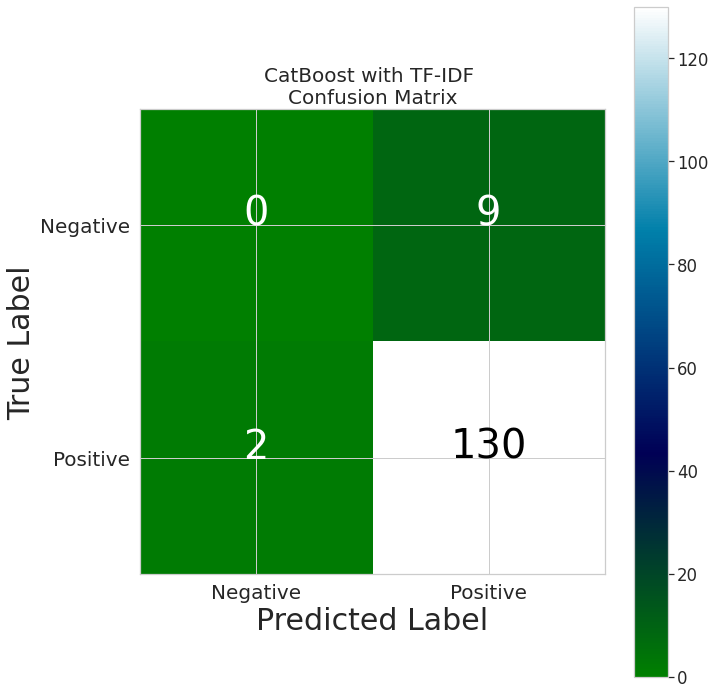

In [185]:
# Print confusion matrix for CatBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_catboost, "CatBoost", "TF-IDF")

In [187]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb, y_pred_tfidf_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

ValueError: ignored

In [189]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



NameError: ignored

In [188]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

NameError: ignored

In [222]:
from keras.preprocessing.text import Tokenizer

samples = X
tokenizer = Tokenizer(lower=True, split=' ') # creates tokenizer
tokenizer.fit_on_texts(samples)  # builds the word index
sequences = tokenizer.texts_to_sequences(samples) #turns strings into list of integers
# word_index is a dictionary mapping words to an integer index
word_index = tokenizer.word_index 
print(f'Found {len(word_index)} unique tokens. ')

Found 5083 unique tokens. 


In [223]:
max([max(sequence) for sequence in sequences])


5083

In [224]:
# Each number is the index of the word in the order of word in original text
sequences[0]

[121,
 4,
 359,
 547,
 677,
 29,
 3,
 7,
 446,
 238,
 3,
 283,
 39,
 18,
 64,
 360,
 2220,
 678,
 1521,
 5,
 9,
 67,
 213,
 239,
 240,
 196,
 5,
 679,
 238,
 1522,
 169,
 65,
 1523,
 2221,
 197,
 284,
 106,
 32,
 8,
 40]

In [225]:
word_index

{'hotel': 1,
 'good': 2,
 'staff': 3,
 'stay': 4,
 'food': 5,
 'service': 6,
 'room': 7,
 'great': 8,
 'really': 9,
 'well': 10,
 'nice': 11,
 'rooms': 12,
 'also': 13,
 'excellent': 14,
 'breakfast': 15,
 'place': 16,
 'one': 17,
 'like': 18,
 'experience': 19,
 'time': 20,
 'us': 21,
 'clean': 22,
 'would': 23,
 'restaurant': 24,
 'stayed': 25,
 'team': 26,
 'helpful': 27,
 'thanks': 28,
 'friendly': 29,
 'bangalore': 30,
 'made': 31,
 'thank': 32,
 'comfortable': 33,
 'amazing': 34,
 'best': 35,
 'visit': 36,
 'mr': 37,
 'special': 38,
 'care': 39,
 'hospitality': 40,
 'always': 41,
 'recommend': 42,
 'day': 43,
 'front': 44,
 'get': 45,
 'property': 46,
 'days': 47,
 'business': 48,
 'reception': 49,
 'chef': 50,
 'pool': 51,
 'location': 52,
 'much': 53,
 'family': 54,
 'every': 55,
 'even': 56,
 'back': 57,
 'overall': 58,
 'wonderful': 59,
 'work': 60,
 'city': 61,
 '’': 62,
 'check': 63,
 'home': 64,
 'manager': 65,
 'come': 66,
 'delicious': 67,
 'dinner': 68,
 'beautiful': 69

In [226]:
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in sequences[0]])

In [227]:
def sequence_to_text(sequence):
    words =  [reverse_word_index.get(letter) for letter in sequence]
    return words

my_text = list(map(sequence_to_text, sequences))

In [228]:
print(sequences[0])


[121, 4, 359, 547, 677, 29, 3, 7, 446, 238, 3, 283, 39, 18, 64, 360, 2220, 678, 1521, 5, 9, 67, 213, 239, 240, 196, 5, 679, 238, 1522, 169, 65, 1523, 2221, 197, 284, 106, 32, 8, 40]


In [229]:
word2vec = gensim.models.Word2Vec(my_text,
                                  size=100,
                                  window=10,
                                  min_count=1)
word2vec.train(my_text, total_examples=25026, epochs=10)

(237204, 274110)

In [234]:
similar_words = {search_term: [item[0] for item in word2vec.wv.most_similar([search_term], topn=5)]
                  for search_term in ['hotel', 'good','service', 'location', 'food', 'staff', 'great','price','love','stay']}
similar_words

{'food': ['service', 'also', 'ambience', 'restaurant', 'spread'],
 'good': ['nice', 'excellent', 'services', 'rooms', 'maintained'],
 'great': ['awesome', 'pleasant', 'amazing', 'ambience', 'overall'],
 'hotel': ['near', 'location', 'decent', 'place', 'beautiful'],
 'location': ['hotel', 'well', 'amenities', 'near', 'decent'],
 'love': ['definitely', 'friends', 'soon', 'visit', 'enjoy'],
 'price': ['area', 'spa', 'large', 'new', 'morning'],
 'service': ['also', 'awesome', 'food', 'polite', 'ambience'],
 'staff': ['especially', 'staffs', 'really', 'friendly', 'comfortable'],
 'stay': ['pleasant', 'wonderful', 'great', 'really', 'awesome']}

<Figure size 1080x2160 with 0 Axes>

Text(0, 0, 'hotel')

Text(0, 0, 'near')

Text(0, 0, 'location')

Text(0, 0, 'decent')

Text(0, 0, 'place')

Text(0, 0, 'beautiful')

Text(0, 0, 'good')

Text(0, 0, 'nice')

Text(0, 0, 'excellent')

Text(0, 0, 'services')

Text(0, 0, 'rooms')

Text(0, 0, 'maintained')

Text(0, 0, 'service')

Text(0, 0, 'also')

Text(0, 0, 'awesome')

Text(0, 0, 'food')

Text(0, 0, 'polite')

Text(0, 0, 'ambience')

Text(0, 0, 'location')

Text(0, 0, 'hotel')

Text(0, 0, 'well')

Text(0, 0, 'amenities')

Text(0, 0, 'near')

Text(0, 0, 'decent')

Text(0, 0, 'food')

Text(0, 0, 'service')

Text(0, 0, 'also')

Text(0, 0, 'ambience')

Text(0, 0, 'restaurant')

Text(0, 0, 'spread')

Text(0, 0, 'staff')

Text(0, 0, 'especially')

Text(0, 0, 'staffs')

Text(0, 0, 'really')

Text(0, 0, 'friendly')

Text(0, 0, 'comfortable')

Text(0, 0, 'great')

Text(0, 0, 'awesome')

Text(0, 0, 'pleasant')

Text(0, 0, 'amazing')

Text(0, 0, 'ambience')

Text(0, 0, 'overall')

Text(0, 0, 'price')

Text(0, 0, 'area')

Text(0, 0, 'spa')

Text(0, 0, 'large')

Text(0, 0, 'new')

Text(0, 0, 'morning')

Text(0, 0, 'love')

Text(0, 0, 'definitely')

Text(0, 0, 'friends')

Text(0, 0, 'soon')

Text(0, 0, 'visit')

Text(0, 0, 'enjoy')

Text(0, 0, 'stay')

Text(0, 0, 'pleasant')

Text(0, 0, 'wonderful')

Text(0, 0, 'great')

Text(0, 0, 'really')

Text(0, 0, 'awesome')

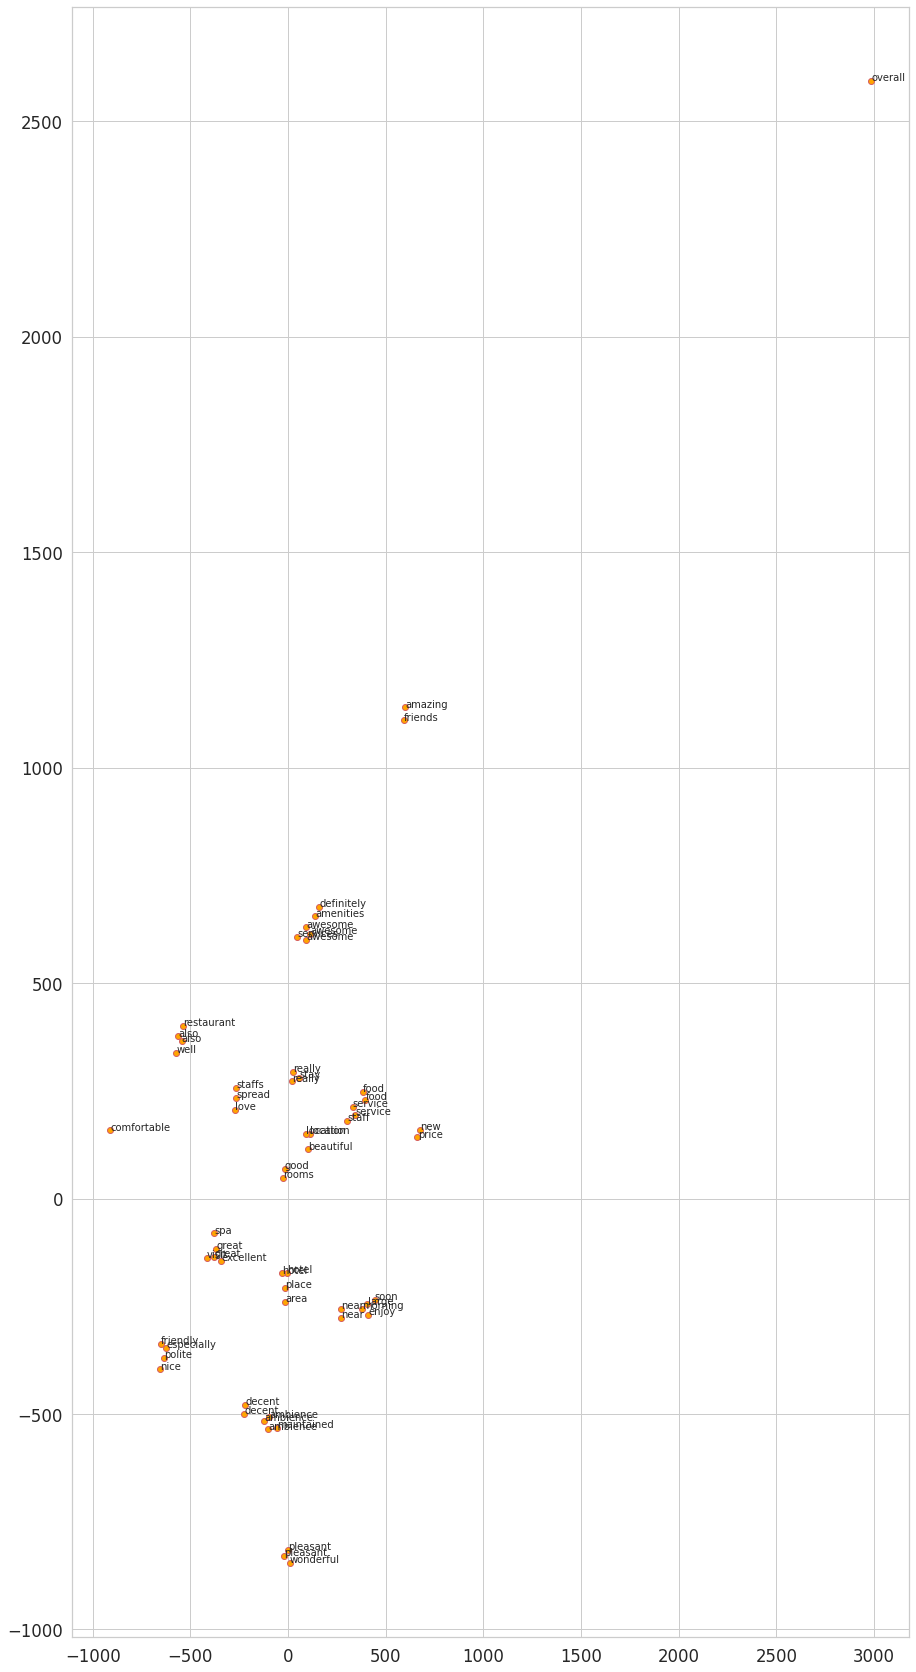

In [239]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = word2vec.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(15, 30))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points')

In [240]:
len(word_index.keys())


5083

In [241]:
len(word2vec.wv.vocab)


5083

In [242]:
from keras.preprocessing.sequence import pad_sequences
max_length = 200 # fix the length of each review 
max_words = len(word_index.keys()) # fix number of words 

training_samples = 6000
validation_samples = 2933
data = pad_sequences(sequences, maxlen=max_length)

#labels = np.asarray(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

x_train = data[:training_samples]
y_train = y[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = y[training_samples: training_samples + validation_samples]
print('Shape of training data: ', x_train.shape)
print('Shape of validation data: ', x_val.shape)

Shape of data tensor: (701, 200)
Shape of label tensor: (701,)
Shape of training data:  (701, 200)
Shape of validation data:  (0, 200)


In [243]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words+1, embedding_dim))
for word , i in word_index.items():
    embedding_vector = word2vec.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [244]:
embedding_matrix.shape


(5084, 100)

In [245]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense


model = Sequential()
model.add(Embedding(max_words+1, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          508400    
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                640032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,148,465
Trainable params: 1,148,465
Non-trainable params: 0
_________________________________________________________________


In [246]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [247]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10


UnimplementedError: ignored

In [248]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored